# <font  color = "#0093AF"> Bloch-McConnell Relaxation Dispersion
    
In solution NMR, if a two-site exchange process leads to modulation of chemical shift, it is in some cases possible to calculate the rate of exchange ($k_{ex}=k_{1\rightarrow2}+k_{2\rightarrow1}$), the change in chemical shift ($\Delta\omega=\Omega_1-\Omega_2$) and also the populations of the two sites ($p_1/p_2=k_{2\rightarrow1}/k_{1\rightarrow2}$), based on a series of $R_{1\rho}$ measurements. However, this depends on the rate of exchange and also the strength of the spin-lock. If the exchange is too fast, it is impossible to separate the populations from the change in chemical shift, obtaining only the product $p_1p_2\Delta\omega_{12}^2$.
    
Furthermore, if only on-resonance $R_{1\rho}$ experiments are applied, it is impossible to determine whether the larger population has the larger or smaller chemical shift, whereas this can be resolved using off-resonant $R_{1\rho}$ experiments. We will investigate this with simulation, and also compare to the formula provided by Miloushev and Palmer.
    
Note that this experiment is also valid in solids, but we must also consider reorientational dynamics.

## Setup

In [1]:
import os
os.chdir('../../../')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

Miloushev and Palmer provide us with the relevant formula$^1$:

$$
\begin{equation}
R_{1\rho}^{ex}=\frac{\sin^2\beta_ep_1p_2\Delta\omega_{12}^2k_{ex}}{\frac{\omega_{e1}^2\omega_{e2}^2}{\omega_e^2}+k_{ex}^2-\sin^2\beta_ep_1p_2\Delta\omega_{12}^2\left(1+\frac{2k_{ex}^2(p_1\omega_{e1}^2+p_2\omega_{e2}^2)}{\omega_{e1}^2\omega_{e2}^2+\omega_e^2k_{ex}^2}\right)}
\end{equation}
$$

with the following definitions:

$$
\begin{eqnarray}
k_{ex}&=&k_{1\rightarrow2}+k_{2\rightarrow1} \\
\Omega&=&p_1\Omega_1+p_2\Omega_2 \\
\Delta\omega_{12}&=&\Omega_1-\Omega_2 \\
\omega_e^2&=&\omega_1^2+\Omega^2 \\
\omega_{e1}^2&=&\omega_1^2+\Omega_1^2 \\
\omega_{e2}^2&=&\omega_1^2+\Omega_2^2 \\
\sin^2\beta_e&=&\frac{\omega_1^2}{\omega_1^2+\Omega^2}
\end{eqnarray}
$$

[1] V.Z. Miloushev, A.G. Palmer. [*J. Magn. Reson.*](https://doi.org/10.1021/cr030413t) **2015**, 177, 221-227

In the above formula, the relative sizes of the three terms in the denominator determine the availability of information from $R_{1\rho}$ experiments. For example, if either the field strength is set to high, or $k_{ex}$ is 
too large, the third term can be neglected, yielding

$$
\begin{equation}
R_{1\rho}^{ex}=\frac{\sin^2\beta_ep_1p_2\Delta\omega_{12}^2k_{ex}}{\frac{\omega_{e1}^2\omega_{e2}^2}{\omega_e^2}+k_{ex}^2}
\end{equation}
$$

In this case, $p_1$ and $p_2$ never appear separately from $\Delta\omega_{12}$, so that we cannot separate their contributions from experimental results. We may control the applied field strength, which modifies $\omega_{e1}^2\omega_{e2}^2/\omega_e^2$, but cannot control $k_ex$. 

Note that if the applied field strength is significantly larger than $\Delta\omega_{12}$, then the last term of the denominator drops out, and the first term simplifies to $\omega_e^2$, yielding

$$
\begin{equation}
R_{1\rho}^{ex}=\frac{\sin^2\beta_ep_1p_2\Delta\omega_{12}^2k_{ex}}{\omega_e^2+k_{ex}^2}
\end{equation}
$$

In the simulations below, we will test some of these behaviors. First, we define a function that can calculate the above formula, which we can use to compare to simulated results.

In [2]:
def R1p_fun(kex,v1,CS1,CS2,p1):
    p2=1-p1 #Population 2
    #Convert to rad/s
    omega1=v1*2*np.pi 
    Omega1=CS1*2*np.pi
    Omega2=CS2*2*np.pi
    
    Omega=p1*Omega1+p2*Omega2 #Average shift
    D_Omega=Omega1-Omega2  #Change in shift
    sin2beta=omega1**2/(omega1**2+Omega**2) #Sine of offset angle
    
    #Effective fields
    omega_e2=omega1**2+Omega**2
    omega_e2_1=omega1**2+Omega1**2
    omega_e2_2=omega1**2+Omega2**2
    
    x=sin2beta*p1*p2*D_Omega**2
    num=x*kex #Numerator
    den1=omega_e2_1*omega_e2_2/omega_e2 #Denominator (1st term)
    den2=kex**2 #Denominator (2nd term)
    den3=x*(1+2*kex**2*(p1*omega_e2_1+p2*omega_e2_2)/(omega_e2_1*omega_e2_2+omega_e2*kex**2))
    print(Omega1,Omega2,CS1,CS2)
    return num/(den1+den2-den3)

## Define parameters, define the spin-system

In [28]:
p1=0.75  #Population 1
p2=1-p1  #Population 2
kex=30000
tc=1/kex     #Correlation time
DelOmega12=500  #Change in Chemical Shift in Hz

ex0=sl.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,Hz=DelOmega12*p2)
_=ex1.set_inter(Type='CS',i=0,Hz=-DelOmega12*p1)

## Build the Liouvillian, add the exchange matrix

In [29]:
L=sl.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space
L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian

print(f'The mean chemical shift is {ex0.CS[0]["Hz"]*p1+ex1.CS[0]["Hz"]*p2:.2f} Hz')
#ex0.CS lists all chemical shifts and their parameters in the system

The mean chemical shift is 0.00 Hz


## Create a propagator with on-resonant spin-lock, calculate $R_{1\rho}$ relaxation

453.4498410585543 -4081.04856952699 72.1687836487032 -649.519052838329


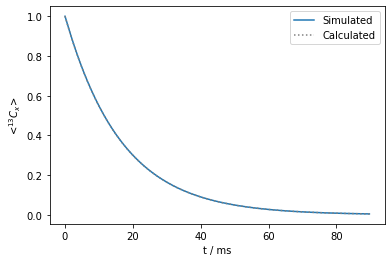

In [32]:
seq=L.Sequence(Dt=.0003)
v1=500
seq.add_channel('13C',v1=v1)  #Spin lock at -3.5 ppm (on-resonance)
U=seq.U()  #Propagator (10 ms)

rho=sl.Rho(rho0='13Cx',detect='13Cx')
n=300
rho.DetProp(U,n=n)

ax=rho.plot(axis='ms')
#ex0.CS/ex1.CS returns a list of all chemical shifts provided during setup with their parameters
R1p=R1p_fun(kex=kex,v1=v1,CS1=ex0.CS[0]['Hz'],CS2=ex1.CS[0]['Hz'],p1=p1)
ax.plot(rho.t_axis*1e3,np.exp(-R1p*rho.t_axis),color='grey',linestyle=':')
ax.legend(('Simulated','Calculated'))

### What happens if we vary the populations and $\Delta\omega_{12}^2$, but leave $p_1p_2\Delta\Omega^2$ fixed?
We start out with fast exchange, i.e. $k_ex>>\Delta\Omega_{12}$ ($k_{ex}=$30000 s$^{-1}$, $\Delta\Omega_{12}$=500x2$\pi$ Hz).

We claim above that for fast exchange, we cannot separate experimentally $p_1$ and $p_2$ from $\Delta\Omega_{12}$. We verify this by fixing the product $p_1p_2\Delta\Omega_{12}^2$, but varying $p_1$.

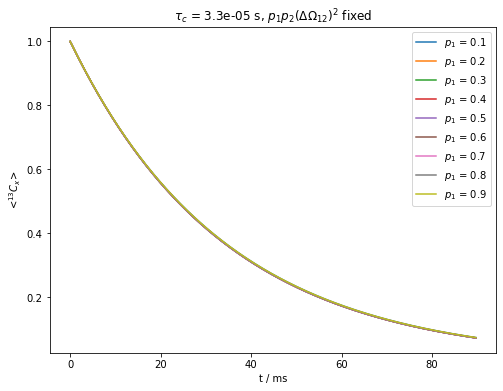

In [45]:
kex=30000
tc=1/kex
ax=plt.subplots()[1]
p1p2Delv12=p1*p2*500**2  #p1*p2*DeltaOmega**2 is fixed below
p10=np.linspace(0.1,.9,9) #Sweep from p1=0.1 to p1=0.9
for p1 in p10:
    p2=1-p1 #Calculate p2
    Delv12=np.sqrt(p1p2Delv12/p1/p2) #Adjust DeltaOmega to keep product fixed
    ex0=sl.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
    ex1=ex0.copy()
    ex0.set_inter(Type='CS',i=0,Hz=Delv12/2)
    ex1.set_inter(Type='CS',i=0,Hz=-Delv12/2)
    L=sl.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space
    L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian
    seq=L.Sequence()
    v0=Delv12/2*p1-Delv12/2*p2
    seq.add_channel('13C',v1=500,voff=v0)  #On-resonant spin-lock
    U=seq.U(.0003)  #Propagator (10 ms)
    rho=sl.Rho(rho0='13Cx',detect='13Cx')
    rho.DetProp(U,n=n)
    rho.plot(axis='ms',ax=ax)
ax.legend([r'$p_1$ = '+f'{p1:.1f}' for p1 in p10])
ax.figure.set_size_inches([8,6])
_=ax.set_title(r'$\tau_c$ = '+f'{tc:.1e} s'+r', '+'$p_1p_2(\Delta\Omega_{12})^2$ fixed')

As we can see above, all relaxation curves are basically identical, showing that we cannot separate the populations from the change in chemical shift. 

On the other hand, if exchange is slower, the curves will separate as we vary the populations. We slow $k_{ex}$ down to 3000 s$^{-1}$

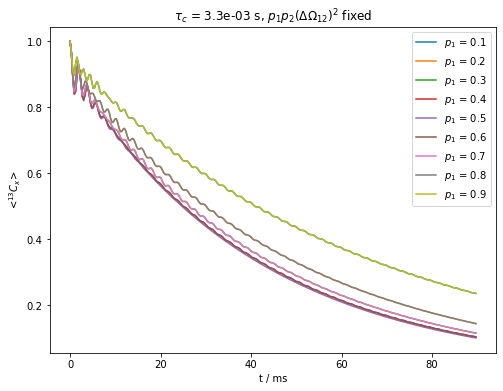

In [37]:
kex=300
tc=1/kex
ax=plt.subplots()[1]
p1p2Delv12=p1*p2*500**2  #p1*p2*DeltaOmega**2 is fixed below
p10=np.linspace(0.1,.9,9) #Sweep from p1=0.1 to p1=0.9
for p1 in p10:
    p2=1-p1 #Calculate p2
    Delv12=np.sqrt(p1p2Delv12/p1/p2) #Adjust DeltaOmega to keep product fixed
    ex0=sl.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
    ex1=ex0.copy()
    ex0.set_inter(Type='CS',i=0,Hz=Delv12/2)
    ex1.set_inter(Type='CS',i=0,Hz=-Delv12/2)
    L=sl.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space
    L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian
    seq=L.Sequence()
    v0=Delv12/2*p1-Delv12/2*p2
    seq.add_channel('13C',v1=500,voff=v0)  #On-resonant spin-lock
    U=seq.U(.0003)  #Propagator (10 ms)
    rho=sl.Rho(rho0='13Cx',detect='13Cx')
    rho.DetProp(U,n=n)
    rho.plot(axis='ms',ax=ax)
ax.legend([r'$p_1$ = '+f'{p1:.1f}' for p1 in p10])
ax.figure.set_size_inches([8,6])
_=ax.set_title(r'$\tau_c$ = '+f'{tc:.1e} s'+r', '+'$p_1p_2(\Delta\Omega_{12})^2$ fixed')

In the case of fast exchange, only the product, $p_1p_2\Delta\Omega_{12}^2$ influences the relaxation, so that we cannot separate populations from the change in chemical shift.

Next, we test for slow exchange, what happens if the field strength is set too high

Text(0.5, 1.0, '$\\tau_c$ = 5.0e-04 s, $p_1p_2\\Delta\\Omega_{12}$ fixed')

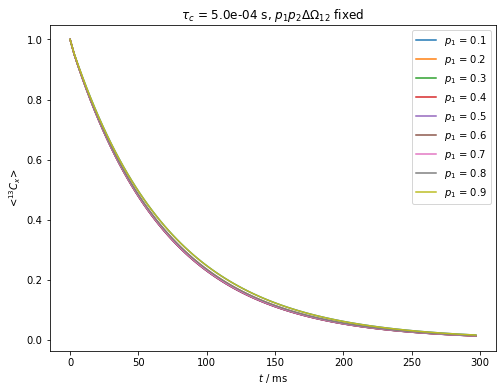

In [8]:
ax=plt.subplots()[1]
tc=5e-4
p10=np.linspace(0.1,.9,9)
p1p2DelOmega2=46875

for p1 in p10:
    p2=1-p1
    DelOmega12=np.sqrt(p1p2DelOmega2/p1/p2)
    ex0=RS.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
    ex1=ex0.copy()
    ex0.set_inter(Type='CS',i=0,ppm=DelOmega12/ex0.v0[0]*1e6*p2)
    ex1.set_inter(Type='CS',i=0,ppm=-DelOmega12/ex0.v0[0]*1e6*p1)
    L=RS.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space
    L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian
    seq=L.Sequence()
    seq.add_channel('13C',v1=2500)  #Spin lock at -3.5 ppm (on-resonance)
    U=seq.U(.003)  #Propagator (10 ms)
    rho=RS.Rho(rho0='13Cx',detect='13Cx')
    rho.DetProp(U,n=100)
    rho.plot(axis='ms',ax=ax)
ax.legend([r'$p_1$ = '+f'{p1:.1f}' for p1 in p10])
ax.figure.set_size_inches([8,6])
ax.set_title(r'$\tau_c$ = '+f'{tc:.1e} s'+r', '+'$p_1p_2\Delta\Omega_{12}$ fixed')

The stronger field slows down the relaxation considerably, but furthermore, no longer can we separate $p_1p_2$ from $\Delta\Omega_{12}$. This becomes critical in solid-state NMR, where we need to be able to apply low fields while retaining a spin-lock. This can become problematic due to other large, anisotropic interactions, such that we need to spin quickly and decrease the $^1$H concentration to avoid higher order effects.

Next, we determine the behavior of relaxation as a function of offset frequency. First, we calculate a spectrum to see where peaks actually appear (and also mark where peaks should be in the absence of exchange).

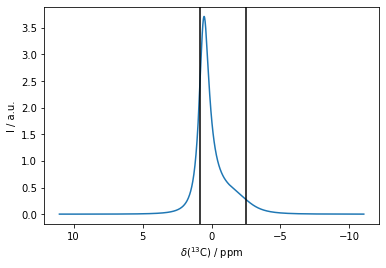

In [9]:
ax=plt.subplots()[1]
tc=5e-4
p1=0.75
p2=1-p1
p1p2DelOmega2=46875
DelOmega12=np.sqrt(p1p2DelOmega2/p1/p2)

ex0=RS.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=DelOmega12/ex0.v0[0]*1e6*p2)
ex1.set_inter(Type='CS',i=0,ppm=-DelOmega12/ex0.v0[0]*1e6*p1)

L=RS.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space
L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian
U=L.U(.0003)  #Propagator (10 ms)
rho0=RS.Rho(rho0='13Cx',detect='13Cp')
rho0.DetProp(U,n=1000)
rho0.plot(axis='ppm',ax=ax,FT=True)
ax.set_ylim(ax.get_ylim())
ax.plot(ex0.inter[0]['ppm']*np.ones(2),ax.get_ylim(),color='black')
ax.plot(ex1.inter[0]['ppm']*np.ones(2),ax.get_ylim(),color='black')

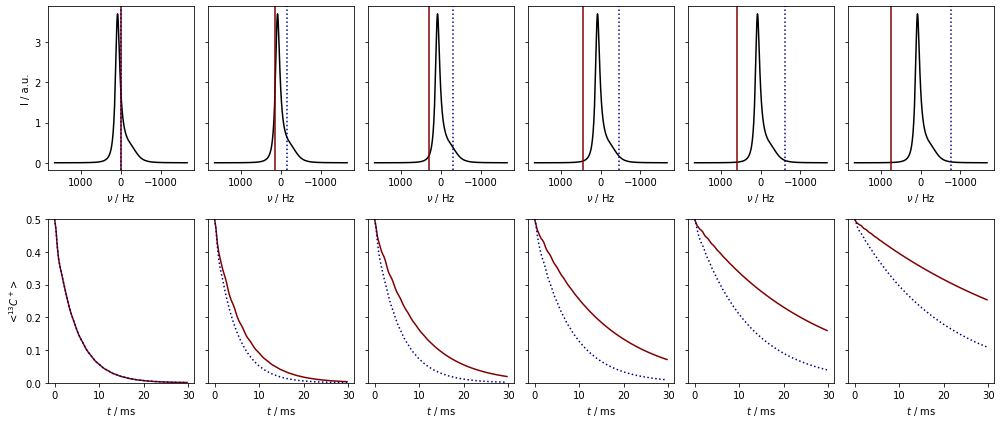

In [10]:
voff0=np.linspace(0,750,6)
tc=5e-4
L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian
U=L.U(.0003)  #Propagator (10 ms)
rho0=RS.Rho(rho0='13Cx',detect='13Cp')
rho0.DetProp(U,n=1000)

fig,ax=plt.subplots(2,len(voff0))
fig.set_size_inches([14,6])
rho=RS.Rho(rho0='13Cz',detect='13Cp')
Dt=.0003
for voff,a in zip(voff0,ax.T):
    a[1].set_ylim([0,.5])
    rho0.plot(FT=True,ax=a[0],axis='Hz',color='black')
    yl=a[0].get_ylim()
    a[0].plot(voff*np.ones(2),yl,color='maroon')
    a[0].plot(-voff*np.ones(2),yl,color='darkblue',linestyle=':')
    a[0].set_ylim(yl)
    
    flip=np.arcsin(500/np.sqrt(500**2+voff**2))
    Uflip0=L.Sequence().add_channel('13C',v1=100000,t=[0,flip/100000/2/np.pi],phase=np.pi/2).U()
    Uflip1=L.Sequence().add_channel('13C',v1=100000,t=[0,(np.pi/2-flip)/100000/2/np.pi+1e-10],phase=np.pi/2).U()
    rho.clear()
    
                   
    seq=L.Sequence().add_channel('13C',v1=-500,voff=voff)
    U=seq.U(Dt)
    for n in range(100):
        rho.reset()
        (Uflip1*(U**n)*Uflip0*rho)()
    rho.plot(axis='ms',ax=a[1],color='maroon')
    
    seq=L.Sequence().add_channel('13C',v1=500,voff=-voff)
    U=seq.U(Dt)
    
    rho.clear()
    for n in range(100):
        rho.reset()
        (Uflip1*(U**n)*Uflip0*rho)()
    rho.plot(axis='ms',ax=a[1],color='darkblue',linestyle=':')
    
    if not(a[0].is_first_col()):
        a[0].set_ylabel('')
        a[0].set_yticklabels('')
        a[1].set_ylabel('')
        a[1].set_yticklabels('')
fig.tight_layout()

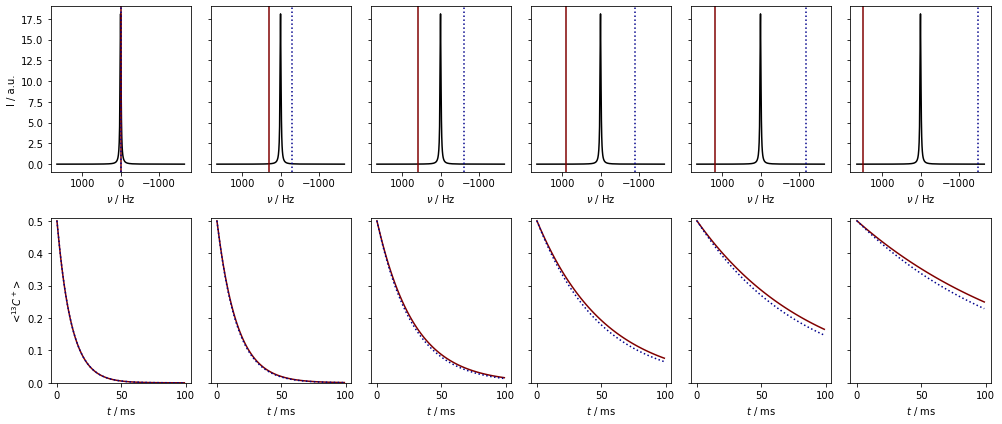

In [11]:
tc=5e-5
L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian

U=L.U(.0003)  #Propagator (.3 ms)
rho0=RS.Rho(rho0='13Cx',detect='13Cp')
rho0.DetProp(U,n=1000)

voff0=np.linspace(0,1500,6)
fig,ax=plt.subplots(2,len(voff0))
fig.set_size_inches([14,6])
rho=RS.Rho(rho0='13Cz',detect='13Cp')
Dt=.001
for voff,a in zip(voff0,ax.T):
    a[1].set_ylim([0,.51])
    rho0.plot(FT=True,ax=a[0],axis='Hz',color='black')
    yl=a[0].get_ylim()
    a[0].plot(voff*np.ones(2),yl,color='maroon')
    a[0].plot(-voff*np.ones(2),yl,color='darkblue',linestyle=':')
    a[0].set_ylim(yl)
    flip=np.arcsin(500/np.sqrt(500**2+voff**2))
    Uflip0=L.Sequence().add_channel('13C',v1=100000,t=[0,flip/100000/2/np.pi],phase=np.pi/2).U()
    Uflip1=L.Sequence().add_channel('13C',v1=100000,t=[0,(np.pi/2-flip)/100000/2/np.pi+1e-10],phase=np.pi/2).U()
    rho.clear()
    
                   
    seq=L.Sequence().add_channel('13C',v1=-500,voff=voff)
    U=seq.U(Dt)
    for n in range(100):
        rho.reset()
        (Uflip1*(U**n)*Uflip0*rho)()
    rho.plot(axis='ms',ax=a[1],color='maroon')
    
    seq=L.Sequence().add_channel('13C',v1=500,voff=-voff)
    U=seq.U(Dt)
    
    rho.clear()
    for n in range(100):
        rho.reset()
        (Uflip1*(U**n)*Uflip0*rho)()
    rho.plot(axis='ms',ax=a[1],color='darkblue',linestyle=':')
    
    if not(a[0].is_first_col()):
        a[0].set_ylabel('')
        a[0].set_yticklabels('')
        a[1].set_ylabel('')
        a[1].set_yticklabels('')
fig.tight_layout()      